# Vanilla Markowitz Model

Import the libraries

In [3]:
import numpy as np
import pandas as pd 

# For portfolio optimization
from scipy.optimize import minimize, LinearConstraint, Bounds
from matplotlib import pyplot as plt
import seaborn as sns

Reading Finance Data

In [4]:
# import the data from  local file
stock_data=pd.read_excel('Daily_Returns.xlsx')

# Convert the 'date' column to datetime format 
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Set the 'date' column as the index
stock_data.set_index('Date', inplace=True)

Breaking training and testing

In [5]:
# Creating the training dataset 
train = stock_data['2000':'2016']

# Creating the testing dataset 
test = stock_data['2017':'2019']

# Creating the out of sample testing dataset 
out_of_sample = stock_data['2020':'2023']

Getting the initial data ready

In [6]:
#Renaming the training data
df = train

In [7]:
# Calculate return for each stock. 
r = np.mean(df,axis=0)

# Create a covariance matrix
covar = df.cov()

In [8]:
#rate of return for the whole portfolio
def ret(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))

#Find the total number of assets we are considering
num_assets = df.shape[1]

Creating the portfolio with the maximum return

In [9]:
# Function to minimize - negative portfolio returns (to maximize returns)
def negative_portfolio_returns(weights):
    return -np.sum(r * weights)


# Define a function to calculate portfolio volatility (risk)
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights, np.dot(weights, covar)))

In [10]:
#Sum of weights should be 1
weight_sum_constraint = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#Weights should be between 0 and 1
bounds = tuple((0, 1) for _ in range(num_assets))

#Initiate the weights
initial_weights = np.ones(num_assets) / num_assets

# Perform MVO optimization
result = minimize(negative_portfolio_returns, initial_weights, method='SLSQP', bounds=bounds, constraints=[weight_sum_constraint])

#Find the weights
w_max = result.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_max)
print("Return: %.2f%%" % (ret(r, w_max) * 100), "Risk:  %.2f%%" % (portfolio_volatility(w_max)*100))

Optimal Weights:
[1.09940827e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.73512905e-17 2.97150619e-17
 8.20917932e-17 0.00000000e+00 3.43407179e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.99533752e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.62850000e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.84448011e-17 0.00000000e+00
 0.00000000e+00 3.57338605e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.20888597e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.83361096e-18 0.00000000e+00
 3.59873753e-18 6.31690758e-17 0.00000000e+00 1.30119091e-19
 0.00000000e+00 8.33981685e-17 2.68616570e-17 1.73027129e-18
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.51875527e-17
 0.00000000e+00 4.24277509e-17 5.79367149e-17 2.05541181e-18
 2.17410524e-17 8.67042409e-18 0.00000000e+00 2.67037603e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.25842784e-18
 0.0000

Creating the portfolio with the minimum risk

In [11]:
# All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
bounds = Bounds(0, 1)

# Set the constraint that the sum of weights equals 1.
constraint_matrix = np.ones((1, num_assets))
linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

# Find a portfolio with the minimum risk.
# Create x0, the first guess at the values of each stock's weight.
initial_weights = np.ones(num_assets) / num_assets

# Minimize the risk function using the 'trust-constr' method with linear constraint and bounds.
res = minimize(portfolio_volatility, initial_weights, method='trust-constr', constraints=linear_constraint, bounds=bounds)

# These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_min)
print("Return: %.2f%%" % (ret(r, w_min) * 100), "Risk:  %.2f%%" % (portfolio_volatility(w_min)*100))

Optimal Weights:
[4.18977243e-04 5.31815233e-04 3.14377034e-03 6.56024894e-04
 4.22070118e-04 4.48743276e-04 6.00459241e-04 6.52311155e-04
 4.31208279e-04 4.22838671e-04 3.44246124e-04 4.28404185e-04
 5.99167610e-04 7.63531332e-04 3.46294613e-04 4.45480995e-04
 4.43782322e-04 4.11125096e-04 5.04177352e-04 3.48838538e-03
 4.27042607e-04 5.35852684e-04 6.26875001e-04 4.98843484e-04
 4.29947270e-04 2.74079657e-03 5.26848330e-04 6.70135998e-04
 5.03479496e-04 5.29044494e-04 4.61996330e-04 1.92651146e-03
 5.16809081e-04 8.78875501e-04 5.20038879e-04 1.23880225e-03
 5.27061001e-04 3.92978147e-04 7.42262264e-04 5.53607291e-04
 3.31505988e-04 8.40712483e-04 4.51024995e-04 8.75954097e-04
 8.41003850e-04 5.11226211e-04 6.78973316e-04 3.73050388e-04
 4.17673851e-04 4.71530583e-04 4.56813839e-04 7.44244543e-04
 8.71263400e-04 8.40499195e-04 5.53368263e-04 4.21181971e-04
 4.86534826e-04 3.11138001e-04 1.07919559e-03 6.88001111e-04
 4.63823169e-04 5.19003004e-04 2.00532843e-03 3.37414832e-04
 4.9597

Finding the efficient frontier

In [12]:
#Let us now find the risk free rate
risk_free_values = [
    1.84 / 100,
    2.14 / 100,
    2.54 / 100,
    2.35 / 100,
    1.80 / 100,
    2.78 / 100,
    3.22 / 100,
    3.26 / 100,
    3.66 / 100,
    4.63 / 100,
    4.80 / 100,
    4.29 / 100,
    4.27 / 100,
    4.01 / 100,
    4.61 / 100,
    5.02 / 100,
    6.03 / 100
]

# Python program to get average of a list 
def Average(lst): 
    return sum(lst) / len(lst) 


# Get the average risk free rate 
rfr = Average(risk_free_values)

#Get the daily risk free rate
rfr = rfr/365

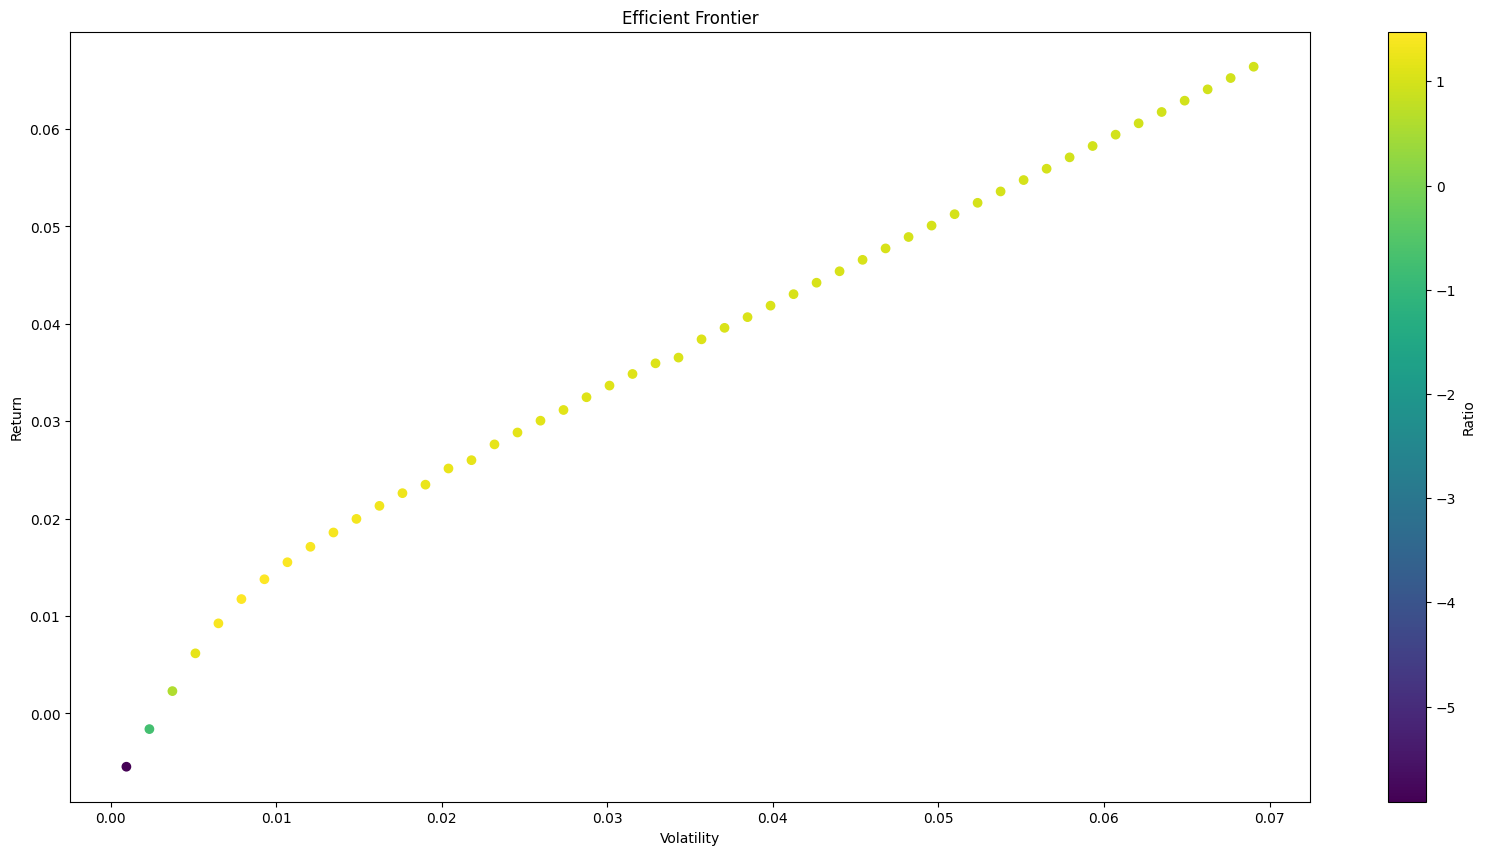

In [13]:
# Define the new objective function to maximize return (minimize negative return)
def negative_portfolio_return(weights):
    return -ret(r, weights)  # We use the previously defined ret function

# Initialize arrays to store portfolio returns, volatilities, and weights
num_ports = 50
all_weights = np.zeros((num_ports, num_assets))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)

# Calculate the gap between portfolio volatilities for equally spaced portfolios
vol_min = portfolio_volatility(w_min)
vol_max = portfolio_volatility(w_max)
gap = (vol_max - vol_min) / (num_ports)

# Loop through to generate portfolios with increasing risk and maximizing return
for i in range(num_ports):
    target_vol = vol_min + i * gap

    # Constraint to ensure sum of weights is 1 and to fix the portfolio volatility
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                    {'type': 'ineq', 'fun': lambda weights: target_vol - portfolio_volatility(weights)}]  # Volatility not more than target
    bounds = Bounds(0, 1)

    #Find the optimum results
    result = minimize(negative_portfolio_return,initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    # Storing the results
    all_weights[i, :] = result.x
    ret_arr[i] = ret(r, result.x)
    vol_arr[i] = target_vol
 

# Calculate Sharpe ratios for each portfolio
sharpe_arr = (ret_arr-rfr)/ vol_arr

# Plotting the Efficient Frontier
plt.figure(figsize=(20, 10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


Finding the portfolio for a risk value of 1%

In [14]:
#Sum of weights must be 1 and the risk must be less than 1%
constraint = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
            {'type': 'ineq', 'fun': lambda weights: 0.01 - portfolio_volatility(weights)}]
                         

#Weights are between 0 and 1
bounds = tuple((0, 1) for _ in range(num_assets))
initial_weights = np.ones(num_assets) / num_assets

# Perform MVO optimization
result = minimize(negative_portfolio_returns, initial_weights, method='SLSQP', bounds=bounds, constraints=constraint)

#Find the weights
w_allocation = result.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_allocation)
print("Return: %.2f%%" % (ret(r, w_allocation) * 100), "Risk:  %.2f%%" % (portfolio_volatility(w_allocation)*100))

Optimal Weights:
[0.00000000e+00 7.90460895e-17 5.14173039e-17 4.47453010e-17
 7.08915668e-17 0.00000000e+00 0.00000000e+00 4.95175556e-17
 0.00000000e+00 0.00000000e+00 6.28757001e-17 4.32854879e-17
 0.00000000e+00 5.40007477e-17 0.00000000e+00 1.72801146e-17
 1.71080052e-18 0.00000000e+00 0.00000000e+00 5.84287170e-17
 0.00000000e+00 8.42885211e-18 3.00087620e-17 0.00000000e+00
 2.03391230e-17 6.95944949e-17 1.42686936e-17 8.46636011e-19
 0.00000000e+00 1.44503985e-17 5.37015385e-18 2.43587779e-17
 0.00000000e+00 5.15986272e-17 0.00000000e+00 1.37923861e-16
 0.00000000e+00 2.53452572e-17 0.00000000e+00 6.03772675e-18
 2.11442342e-17 1.74403489e-17 0.00000000e+00 7.66653098e-18
 4.96459842e-17 1.50358578e-18 3.47710990e-18 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.73807325e-18
 1.36889684e-17 0.00000000e+00 1.87968872e-18 0.00000000e+00
 0.00000000e+00 8.25712314e-17 7.64695361e-17 1.86848985e-17
 0.00000000e+00 5.87937805e-18 3.19539916e-17 0.00000000e+00
 0.0000

Creating the asset allocation chart

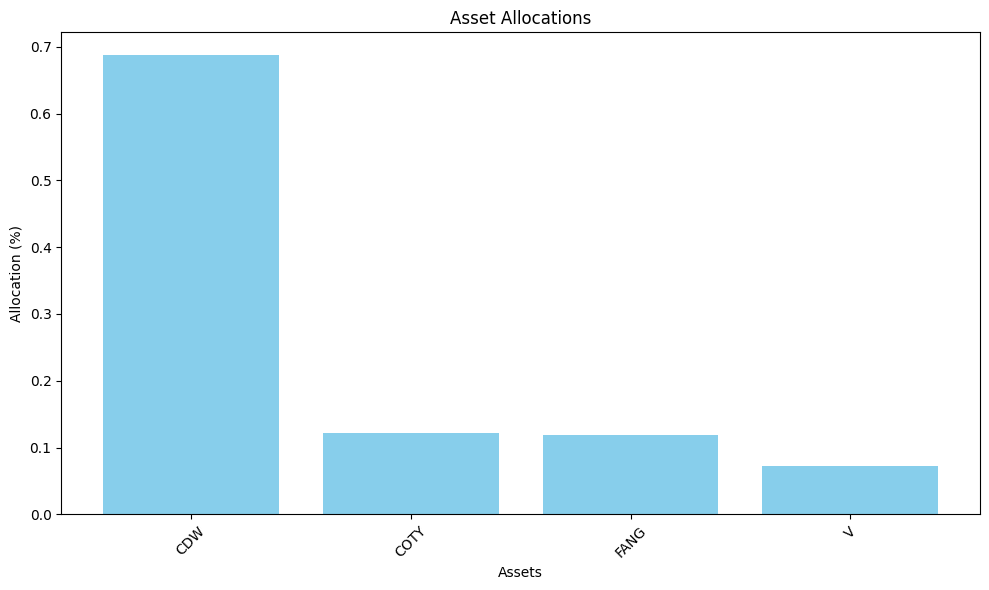

In [15]:
column_names = df.columns.tolist()

# Filter the weights and corresponding names for weights > 0.01
filtered_weights = [w for w in w_allocation if w > 0.01]
filtered_names = [column_names[i] for i, w in enumerate(w_allocation) if w > 0.01]
# Plotting the bar chart
plt.figure(figsize=(10, 6)) 
plt.bar(filtered_names, filtered_weights, color='skyblue') 
plt.xlabel('Assets')  # Adding x-label
plt.ylabel('Allocation (%)')  # Adding y-label
plt.title('Asset Allocations')  # Adding title
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability if names are long
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

Creating the correlation heatmap

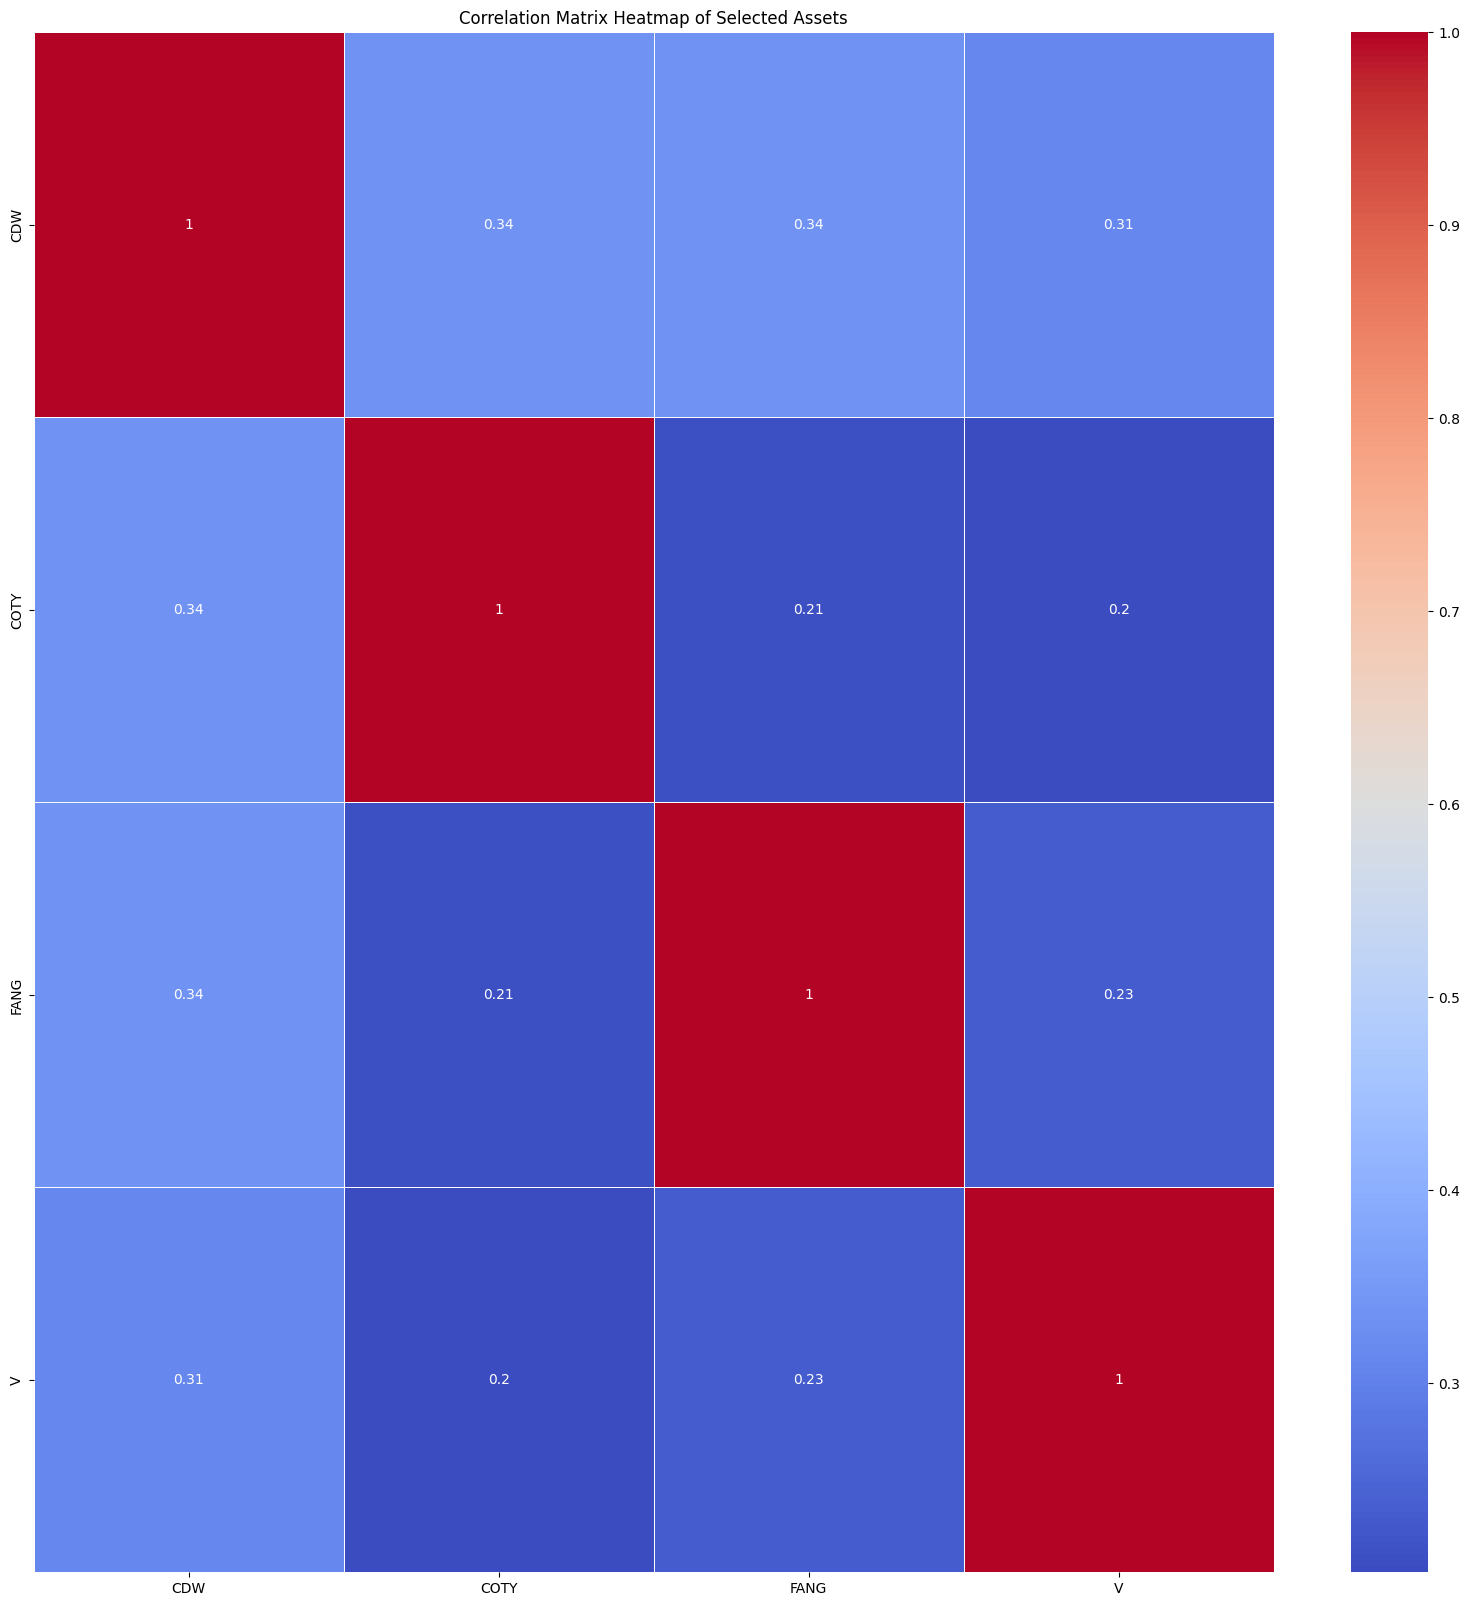

In [16]:
# Filter columns in df where the corresponding weight in w_min is greater than 0
filtered_df = df[filtered_names]

# Compute the correlation matrix
corr_matrix = filtered_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap of Selected Assets')
plt.show()


Now let us create a dataframe of results

In [17]:
#Get the values
returns = ret(r, w_allocation) * 100
risk = portfolio_volatility(w_allocation)*100

# Append the values to the DataFrame
new_row = pd.DataFrame({'return': [returns], 'risk': [risk]})

#Save the dataframe
new_row.to_excel("Vanilla_Results.xlsx",index=False)

Testing the model

In [22]:
# Calculate expected returns for each asset
expected_returns_test = np.mean(out_of_sample,axis=0)

#Converting the expected returns to a numpy array
expected_returns_test = expected_returns_test.values

In [23]:
#Actual Return
Actual_Return_out_of_Sample = ret(expected_returns_test, w_allocation) 
print(Actual_Return_out_of_Sample )

0.0008535196087374709


In [24]:
# Calculate expected returns for each asset
expected_returns_test = np.mean(test,axis=0)

#Converting the expected returns to a numpy array
expected_returns_test = expected_returns_test.values

In [25]:
#Actual Return
Actual_Return = ret(expected_returns_test, w_allocation) 
print(Actual_Return)

0.001126598972806783
